#  A short introduction

We are working on a project to color grayscale pictures.
The first few aspect of our project that we would like to introduce in this short introduction, are the decisions we took in our current approach to the problem.

The Dataset:
At first we were planning on using the ImageNet Database, but soon it became evident, that due to some technical difficulties on the site we weren't going to get access, so we decided on our current Database (Open Images V4 Dataset) which granted us the original images in a zip file. The images are not restricted to a single subject, the dataset incorporates images with various themes. We decided to start with 100000 images.
(https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/)

The Images:
Although the Images in the Database were mostly satisfactory for our goals, there were some modifications we had to make on them. Since the images were too big for us to handle and they did not have the same measurements we decided to crop them into a square shape and scale them down to resolution of 128X128. Also some of the pictures were not appropriate for our task such as grayscale pictures, so we decided, to sort them out.

The LAB color scale:
We decided to convert the images from RGB color space to LAB, which hopefully will make the teaching easier, as the L channel of LAB colorspace is the greyscale representation of the image, so the machine will only have to predict two channels instead of 3.

Normalization:
We decided to normalize the whole dataset as a preprocessing step, load every image to a numpy array, normalize it, then save it to a csv file, resulting in a normalized dataset of csv files. This way we can avoid the normalization of the images in every training step.

The Small Parts:
Even with a 128X128 scaling the whole dataset is too big to be loaded to the operating memory as a numpy array, so we decided to divide it into smaller parts, and teach the neural network on each smaller part individually.

This version contains only the result of a single training step with 1000 images and 10 epochs.

# The preparation and preprocessing of the dataset

In [22]:
# Importing the used packages

# Numpy for arrays
import numpy as np
# requests for downloading the dataset
import requests
# PIL.Image for image processing
from PIL import Image
# keras.preprocessing.image for image processing
import keras.preprocessing.image as k_image
# os for file management
import os
# skimage.color for transforming the color model of images
import skimage.color as skcolor
# zipfile for extracting downloaded dataset 
import zipfile
# random for random number generation in grayscale check
import random
# datetime for making timestamps
import datetime
# pyplot from Matplotlib for vizualising the test results in plots
import matplotlib.pyplot as plt
%matplotlib inline
# Math for Sqrt
import math
# Genfromtxt to convert our csv file to array
from numpy import genfromtxt
# Keras.* for building my fully connected dense neural network 
from keras.models import Sequential
from keras.layers.core import Dense, Activation,Flatten
from keras.callbacks import Callback
from keras.optimizers import SGD
# Mean_squared_error from sklearn.metrics for calculating mean squared error
from sklearn.metrics import mean_squared_error
# keras.callbacks.* for Earlystopping (modelcheckpoint is needed to load back the weights)
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [24]:
#Function for converting RGB images from path to LAB images.
# path:          String, filepath of the images
# return value:  Float array 128x128x3, The array of the images in LAB colorization
def path2labimage(path):
  #Opening the image from path and converting it to float array
  raw_image_array = np.array(Image.open(path)).astype('float32')
  #Converting RGB image to LAB
  image_array = skcolor.rgb2lab(raw_image_array/255)
  #Returning the float array with the LAB image values
  return image_array

In [25]:
#Function for normalizing the images and saving it to csv files.
# initial_path:          String, filepath of the images
# target_path:           String, intended folder path of csv files
# array_average:         Int, the average value of the train dataset
# array_std:             Int, the standard deviation value of the train dataset
def dataset_normalized_csv(initial_path,target_path,array_average,array_std):
    # Creating directory for the transformed dataset, if it does not exist.
    if not os.path.exists(target_path):
        os.makedirs(target_path)
      
    # Variables for printing the number of already normalized images.
    i=0
    t1=datetime.datetime.now()
    # Iterating over the raw images.
    for filename in os.listdir(initial_path):
        
        # Print the number of normalized images in every minute.
        t2 = datetime.datetime.now()
        if(t2.minute != t1.minute):
            print(str(i)+'/'+str(len(os.listdir(initial_path))))
            t1=t2
        i+=1
        
        #Converting path to LAB image
        image_array = path2labimage(initial_path + filename)
        #Normalizing the grayimage
        image_array[:,:,0] = (image_array[:,:,0]-array_average)/array_std
        #Min max scaling the color dimensions
        image_array[:,:,1::] = image_array[:,:,1::]+128
        image_array[:,:,1::] = image_array[:,:,1::]/255
        #Saving to a csv files
        np.savetxt((target_path + filename[:-3] + 'csv'), image_array.reshape((-1,3)), delimiter=",")


In [26]:
#Function for calculating the average and standard ddeviation of the dataset.
# initial_path:           String, path of the folder of the transformed dataset
# image size              int, size of the images
# valid_split             float32, split of the validation data
# test_split              float32, split of the test data
# return value            standard deviation, average
def dataset_std(initial_path, image_size, valid_split, test_split):
    NA = image_size*image_size;
    NB = 0;
    SA = 0;
    SB = 'a';
    a_ave = 0;
    b_ave = 0;
    
    for filename in os.listdir(initial_path):

        image_array = path2labimage(initial_path + filename)
        SA = np.std(image_array[:,:,0])
        a_ave = np.average(image_array[:,:,0])
        if(SB=='a'):
            SB = SA
            NB += NA
            b_ave = a_ave;
        else:
            SB =math.sqrt(((NA-1)*(SA**2)+(NB-1)*(SB**2)+NA*NB/(NA+NB)*math.pow(a_ave-b_ave,2))/(NA+NB-1))
            b_ave = (b_ave*NB+a_ave*NA)/(NB+NA)
            NB += NA

    return  SB,b_ave   

In [27]:
# Function for downloading the dataset.
# url:           String, url of the zipped dataset
# target_path:   String, intended filepath of the downloaded dataset
def download_dataset(url, target_path):
    # Downloading the file in chunks to avoid memory overrun.
    r = requests.get(url, stream = True)
    with open(target_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            # Filtering out keep-alive new chunks.
            if chunk: 
                f.write(chunk)

In [28]:
#Function for extracting zipped dataset.
# dataset_zipped_path:   String, filepath of the zipped dataset
# raw_dataset_path:      String, intended folder path of raw dataset
# return value:          String, final folder path of raw dataset
def extract_dataset(dataset_zipped_path, raw_dataset_path):
    # Creating directory for the raw dataset, if it does not exist.
    if not os.path.exists(raw_dataset_path):
        os.makedirs(raw_dataset_path)
    
    # Extracting dataset to the intended folder path.
    zip_ref = zipfile.ZipFile(dataset_zipped_path, 'r')
    zip_ref.extractall(raw_dataset_path)
    zip_ref.close()
    
    # Determining and returning final path of the raw dataset.
    dirlist = os.listdir(raw_dataset_path)    
    return raw_dataset_path + dirlist[0] + '/'

In [29]:
# Function for grayscale check of an image. Returns True if grayscale, False if not.
# im:            PIL.Image object, input image
# return value:  boolean, True if grayscale, False if not grayscale
def is_gray_scale(im):
    w,h = im.size
    # Generating 10 random pixel coordinate.
    rand_pixel_array = np.zeros((10,2))
    for i in range(10):
        rand_pixel_array[i,:] = [random.randint(0,w-1), random.randint(0,h-1)]
    # If all of the 10 pixels have the same values on each channels, the image is regarded grayscale.
    for i in range(10):
        r,g,b = im.getpixel((rand_pixel_array[i,0], rand_pixel_array[i,1]))
        if r != g != b: return False
    return True

In [30]:
# Function for dimension check of an image. Returns True if if image has the proper dimensions (3D, 3 channels), False if not.
# im:            PIL.Image object, input image
# return value:  boolean, True if image has the proper dimensions (3D, 3 channels), False if not
def has_proper_dim(im):
    # Get the image data to numpy array.
    im_array = np.array(im)
    shape = im_array.shape
    # The image shall have 3 dimensions, and 3 channels.
    if((len(shape) != 3) or (shape[2] != 3)):
        return False
    else:
        return True    

In [31]:
# Function for making the images to 1:1 ratio, and resizing them to the target size.
# im:           PIL.Image object, input image
# target_size:  tuple with 2 integer element, (width, height)
# return value: PIL.Image object, transformed image
def crop_resize_Image(im, target_size):
    # Taking out the image data (width,height).
    width,height = im.size
    # Deciding if the image is landscape or portrait.
    if(width > height):
        # Landscape
        top     = 0
        left    = int((width - height)/2)
        bottom  = height
        right    = width - int((width - height)/2)
    else:
        # Portrait.
        top     = int((height - width)/2)
        left    = 0
        bottom  = height-int((height - width)/2)
        right    = width
    # Cropping the image to conform 1:1 ratio, the resizing to target size.
    return im.crop((left,top,right,bottom)).resize(target_size)

In [32]:
# Function for standardizing the input array.
# array:          numpy array, input array
# return value:   numpy array, standardized input array
def standardize(array):
    # Calculating average on all elements of the array.
    ave = np.average(array)
    # Calculating standard deviation on all the elements of the array.
    std = np.std(array)
    # Standardizing the input array.
    new_array = (array-ave)/std
    # Returning standardized array.
    return new_array

In [33]:
# Function for transforming the images of the dataset to 1:1 ratio, and target size.
# initial_path:  String, folder path of the raw dataset
# target_path:   String, intended folder path of the transformed dataset
# image_size:    tuple with 2 integer element, (width, height)
def dataset_transform(initial_path, target_path, image_size):
    # Creating directory for the transformed dataset, if it does not exist.
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    # Iterating over the raw images.
    for filename in os.listdir(initial_path):
        im = Image.open(initial_path + filename)
        # Filtering out the grayscale images, and images with improper dimensions.
        if((is_gray_scale(im) == False) and (has_proper_dim(im) == True)):
            # Making the images to 1:1 ratio, and resizing them to the target size.
            im = crop_resize_Image(im,(128,128))
            # Saving the images to the target directory.
            im.save(target_path + filename)

In [34]:
# Function to preprocess the given number of images from the given offset to form training and validation data.
# dataset_path:  String, folder path of the dataset
# train_spl:     float, proportion of training data to all data
# valid_spl:     float, proportion of validation data to all data
# num_imgs:      int, number of images to preprocess
# offset:        int, image index offset in dataset folder
# return value:  training data input, training data output, validation data input, validation data output
def preprocess_train_valid_data(dataset_path, train_spl, valid_spl, num_imgs, offset):
    
    # Determine validation split when taking to account only training and validation data.
    valid_split = valid_spl / (train_spl + valid_spl)
    
    # Making a list of filenames of the dataset directory.
    filename_list = os.listdir(dataset_path)
    # Creating an empty list for the loaded images.
    data = []
    # Iterating over the given number of images from the given offset in the dataset.
    for i in range(offset, (offset + num_imgs)):
        # Loading the actual image, then converting that to a numpy array.
        csv = np.genfromtxt(dataset_path + filename_list[i], delimiter=',')
        image = csv.reshape(128,128,3)
        # Appending image to the list.
        data.append(image)  

    # Creating a numpy array from the list, with float32 datatype.
    data = np.asarray(data, dtype='float32')
    # Selecting the first channel of the images as input, that contains the grayscale representation of the image in lAB color space.
    X = data[:,:,:,0]
    # Selecting the second and third channels of the images as output, they contain green–red and blue–yellow color components respectively.
    Y = data[:,:,:,1:]
    
    # Selecting training and validation data separately.    
    X_train = X[0:int(num_imgs*(1-valid_split)),:,:]
    Y_train = Y[0:int(num_imgs*(1-valid_split)),:,:,:]
    X_valid = X[int(num_imgs*(1-valid_split)):,:,:]
    Y_valid = Y[int(num_imgs*(1-valid_split)):,:,:,:]
    
    return X_train,Y_train,X_valid,Y_valid

In [35]:
# Function to preprocess the given number of images from the given offset to form test data.
# dataset_path:  String, folder path of the dataset
# num_imgs:      int, number of images to preprocess
# offset:        int, image index offset in dataset folder
# return value:  test data input, test data output
def preprocess_test_data(dataset_path, num_imgs, offset):
    
    # Making a list of filenames of the dataset directory.
    filename_list = os.listdir(dataset_path)
    # Creating an empty list for the loaded images.
    data = []
    # Iterating over the given number of images from the given offset in the dataset.
    for i in range(offset, min(offset + num_imgs,len(filename_list))):
        # Loading the actual image, then converting that to a numpy array.
        csv = np.genfromtxt(dataset_path + filename_list[i], delimiter=',')
        image = csv.reshape(128,128,3)
        # Appending image to the list.
        data.append(image) 

    # Creating a numpy array from the list, with float32 datatype.
    data = np.asarray(data, dtype='float32')
    # Selecting the first channel of the images as input, that contains the grayscale representation of the image in lAB color space.
    X_test = data[:,:,:,0]
    # Selecting the second and third channels of the images as output, they contain green–red and blue–yellow color components respectively.
    Y_test = data[:,:,:,1:]
    
    return X_test, Y_test

In [36]:
# Function for converting RGB image array to grayscale image array.
def img_grayscale(imageArray):
    
    imgArr= np.empty([1])
    for image in imageArray:
        pil_imgray = image.convert('LA')
        img = np.array(list(pil_imgray.getdata(band=0)), int)
        img.shape = (pil_imgray.size[1], pil_imgray.size[0])
        imgArr=np.append(imgArr,img)
    imgArr = np.delete(imgArr,0)
    imgArr.shape = (len(imageArray),pil_imgray.size[1], pil_imgray.size[0])
    return imgArr;

In [37]:
# Function for making visualization for the images.
# transformed_dataset_path   String, folder path of transformed dataset
# width                      int, number of images on one edge
# size                       int, size of 1:1 ratio image
def image_mosaic(transformed_dataset_path, width, size):
    
    # Making a list of filenames of the dataset directory.
    filename_list = os.listdir(transformed_dataset_path)
    # Creating an empty list for the loaded images.
    imagearray = []
    # Loading the first width*width number of images, and appending them to the list.
    for i in range(width*width):
        im = Image.open(transformed_dataset_path + filename_list[i])
        imagearray.append(im)
        
    # Initializing canvas.
    canvas = np.ones((size*width,size*width*2,3));
    # Resizing images.
    for i in range(len(imagearray)):
        imagearray[i]=imagearray[i].resize((size,size),Image.ANTIALIAS)
    # Making GrayImages.
    grayimage=img_grayscale(imagearray)
    # Writing the RGB images to the canvas right side.
    for i in range(width):
        for j in range(width):
            canvas[i*size:(i+1)*size,j*size:(j+1)*size,0::]=np.array(imagearray[i+width*j])
    # Writing grayscale images to the canvas left side.
    for i in range(width):
        for j in range(width,2*width):
            canvas[i*size:(i+1)*size,j*size:(j+1)*size,0]=np.array(grayimage[i+width*(j-width)])
            canvas[i*size:(i+1)*size,j*size:(j+1)*size,1]=np.array(grayimage[i+width*(j-width)])
            canvas[i*size:(i+1)*size,j*size:(j+1)*size,2]=np.array(grayimage[i+width*(j-width)])
            
    # Displaying the mosaic.
    canvas = canvas.astype(np.uint8);
    mosaic = Image.fromarray(canvas)
    mosaic.show()

In [38]:
#Class TrainingHistory
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.valid_losses =[]
        self.accs = []
        self.valid_accs = []
        self.epoch=0
    
    def on_epoch_end(self, epoch,logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
#Initializing the history  
history = TrainingHistory()

#Defining the earlystopping
es = EarlyStopping(patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

In [39]:
# Creation of the neural network model.
model = Sequential();
model.add(Conv2D(data_format="channels_first",input_shape=(128, 128,1), filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(data_format="channels_first",filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(data_format="channels_first",filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(data_format="channels_first",filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(data_format="channels_first",filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='linear', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Flatten())
model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(2*128*128, activation='linear'))
model.add(Activation('sigmoid'))  

In [40]:
# Specifying train, validation and test split values.
train_split = 0.8
valid_split = 0.1
test_split = 0.1
# Specifying intended filepath for the dataset to be downloaded.
dataset_zipped_path = os.getcwd() + '/zipped_dataset.zip'
# Specifying intended folder path of raw dataset.
raw_dataset_path = os.getcwd() + '/raw_dataset/'
# Specifying intended folder path of transformed dataset.
transformed_dataset_path = 'C:/Users/USER/Documents/datasets/transformed_dataset/'
# Specifying intended folder for standardized dataset.
csv_dataset_path ='E:/Deep_Learning_HW/csv_dataset/'

In [ ]:
# Specifying input image size.
image_size = (128,128)
# Specifying maximal number of images that can be loaded into memory at one time.
max_loaded_imgs_num = 1000

print('Start zip file download. '+str(datetime.datetime.now()))
# Downloading zipped dataset.
download_dataset('https://datasets.figure-eight.com/figure_eight_datasets/open-images/test_challenge.zip', dataset_zipped_path)
print('Zip file downloaded. '+str(datetime.datetime.now()))

print('Start images extraction. '+str(datetime.datetime.now()))
# Extracting zipped dataset to the intended folder path.
raw_dataset_path = extract_dataset(dataset_zipped_path, raw_dataset_path)
print('Images are extracted. '+str(datetime.datetime.now()))

print('Start dataset transforming. '+str(datetime.datetime.now()))
# Transforming raw dataset to the proper format. 
dataset_transform(raw_dataset_path, transformed_dataset_path, (128,128))
print('Dataset is transformed. '+str(datetime.datetime.now()))

print('Start calculating average and std value on train data. '+str(datetime.datetime.now()))
std,ave = dataset_std(transformed_dataset_path,128,valid_split,test_split)
print('Calculated average and std value, '+str(datetime.datetime.now()))

print('Start transforming images to csv files. '+str(datetime.datetime.now()))
dataset_normalized_csv(transformed_dataset_path,csv_dataset_path,ave,std)
print('Transformed images to csv files. '+str(datetime.datetime.now()))

# Visualization dataset by displaying a mosaic.
image_mosaic(transformed_dataset_path, 10, 64)

# Determining the length of the dataset.
len_dataset = len(os.listdir(transformed_dataset_path))

# Since the whole dataset cannot be loaded to the memory at the same time, the training of the network will be
# executed in cycles. In each cycle (except the last) a predetermined number of images (max_loaded_imgs_num) are
# loaded to the memory, where they are preprocessed and split to training and validation datasets. Then epoch
# number of training and validation phase are executed on the neural network with these datasets. The images
# loaded to the memory are different in every cycle.

# Determining the combined length of the training and validation data.
len_train_val_set = (int)(len_dataset*(train_split+valid_split))
# Determinde number of (training + validation) cycles.
num_cycles_train_val = (int)(len_train_val_set/max_loaded_imgs_num) + 1
# Determine the length of the last section of (training + validation) data.
len_last_section_train_val = len_train_val_set - max_loaded_imgs_num * (num_cycles_train_val - 1)

# Since the whole dataset cannot be loaded to the memory at the same time, the network evaluation on test data
# will be executed in cycles. In each cycle (except the last) a predetermined number of images (max_loaded_imgs_num)
# are loaded to the memory, where they are preprocessed, forming the test dataset. Then the test phase is executed
# on the neural network with this dataset. The images loaded to the memory are different in every cycle.

# Determining the length of the test data.
len_test_set = len_dataset - len_train_val_set
# Determinde number of test cycles.
num_cycles_test = (int)(len_test_set/max_loaded_imgs_num) + 1
# Determine the length of the last section of test data.
len_last_section_test = len_test_set - max_loaded_imgs_num * (num_cycles_test - 1)

# Execution of (num_cycles_train_val-1) training cycle.
#for i in range(num_cycles_train_val-1):
#    (X_train,Y_train,X_valid,Y_valid) = preprocess_train_valid_data(transformed_dataset_path, train_split, valid_split, max_loaded_imgs_num, i * max_loaded_imgs_num)
    # training the model

# If there are images left in the last section, execute last training cycle.
#if(len_last_section_train_val != 0):    
#    (X_train,Y_train,X_valid,Y_valid) = preprocess_train_valid_data(transformed_dataset_path, train_split, valid_split, len_last_section_train_val, (num_cycles_train_val - 1) * max_loaded_imgs_num)
    # training the model

# Execution of (num_cycles_test-1) test cycle.
#for i in range(num_cycles_test-1):
#    (X_test, Y_test) = preprocess_test_data(transformed_dataset_path, max_loaded_imgs_num, len_train_val_set + i * max_loaded_imgs_num )
    # elvaluation of test data

# If there are images left in the last section, execute last test cycle.
#if(len_last_section_test != 0):
#    (X_test, Y_test) = preprocess_test_data(transformed_dataset_path, len_last_section_test, len_train_val_set + (num_cycles_test - 1) * max_loaded_imgs_num )
    # evaluation of test data

In [41]:
sgd=SGD(lr=1, momentum=0.09, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

(X_train,Y_train,X_valid,Y_valid) = preprocess_train_valid_data(csv_dataset_path, train_split, valid_split, 1000, 0)

hst = model.fit(X_train.reshape((-1,128,128,1)), Y_train.reshape((-1,2*128*128)),\
         batch_size=1,
         epochs=10,
         verbose=2,
         validation_data=(X_valid.reshape((-1,128,128,1)),Y_valid.reshape((-1,2*128*128))),
         callbacks=[mcp, es, history],
         shuffle=True)

Train on 888 samples, validate on 112 samples
Epoch 1/10
 - 331s - loss: 210636.9569 - val_loss: 209126.8870

Epoch 00001: val_loss improved from inf to 209126.88700, saving model to weights.hdf5
Epoch 2/10
 - 328s - loss: 210788.7349 - val_loss: 209126.8870

Epoch 00002: val_loss did not improve from 209126.88700
Epoch 3/10
 - 319s - loss: 210788.7349 - val_loss: 209126.8870

Epoch 00003: val_loss did not improve from 209126.88700
Epoch 4/10
 - 331s - loss: 210788.7349 - val_loss: 209126.8870

Epoch 00004: val_loss did not improve from 209126.88700
Epoch 5/10
 - 326s - loss: 210788.7349 - val_loss: 209126.8870

Epoch 00005: val_loss did not improve from 209126.88700
Epoch 6/10
 - 329s - loss: 210788.7349 - val_loss: 209126.8870

Epoch 00006: val_loss did not improve from 209126.88700
Epoch 7/10
 - 320s - loss: 210788.7349 - val_loss: 209126.8870

Epoch 00007: val_loss did not improve from 209126.88700
Epoch 8/10
 - 322s - loss: 210788.7349 - val_loss: 209126.8870

Epoch 00008: val_los

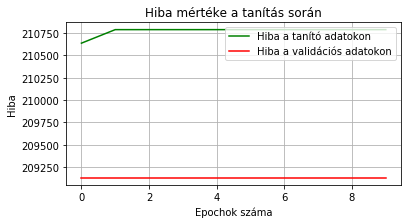

In [42]:
plt.figure(figsize=(6,3))
plt.title("Hiba mértéke a tanítás során")
plt.plot(np.arange(history.epoch), history.losses, color='g',  
         label="Hiba a tanító adatokon")
plt.plot(np.arange(history.epoch), history.valid_losses, color='r',
         label="Hiba a validációs adatokon")
plt.legend(loc='upper right')
plt.xlabel("Epochok száma")
plt.ylabel("Hiba")
plt.grid(True)
plt.show()

In [111]:
std = 28.18332749171332
ave = 47.16514176432521
mosaic_width = 10;
size = 128;
num_imgs = mosaic_width*mosaic_width;
(X_test, Y_test) = preprocess_test_data(csv_dataset_path, num_imgs , 8000)
preds = model.predict(X_test.reshape((-1,128,128,1)))
preds = preds.reshape((-1,128,128,2))
original_images = np.empty((num_imgs,128,128,3), dtype = 'float64')
predicted_images = np.empty((num_imgs,128,128,3), dtype = 'float64')
gray_channel = X_test * std + ave
original_images[:,:,:,0] = gray_channel;
predicted_images[:,:,:,0] = gray_channel;

color_channels_original = Y_test * 255 -128
original_images[:,:,:,1:] = color_channels_original;

color_channels_predicted = preds * 255 - 128
predicted_images[:,:,:,1:] = color_channels_predicted;

for i in range (num_imgs):
    original_images[i,:,:,:] = skcolor.lab2rgb(original_images[i,:,:,:])
    predicted_images[i,:,:,:] = skcolor.lab2rgb(predicted_images[i,:,:,:])
    
im = k_image.array_to_img(predicted_images[5,:,:,:])
im.show()
im = k_image.array_to_img(original_images[5,:,:,:])
im.show()
    
original_images.astype('uint8')
predicted_images.astype('uint8')
    
# Initializing canvas.
canvas = np.zeros((size*mosaic_width,size*mosaic_width*2,3), dtype = 'uint8');
# Writing the RGB images to the canvas right side.
for i in range(mosaic_width):
    for j in range(mosaic_width):
        canvas[i*size:(i+1)*size,j*size:(j+1)*size,:]= original_images[i*mosaic_width+j,:,:,:]
# Writing grayscale images to the canvas left side.
for i in range(mosaic_width):
    for j in range(mosaic_width,2*mosaic_width):
        canvas[i*size:(i+1)*size,j*size:(j+1)*size,:]= predicted_images[i*mosaic_width+(j-mosaic_width),:,:,:]

# Displaying the mosaic.
canvas = canvas.astype(np.uint8);
mosaic = Image.fromarray(canvas)
#mosaic = k_image.array_to_img(canvas)
mosaic.show()

C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 3086 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 13941 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7487 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 4804 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 10553 pixels
  warn('Color data out of range: Z < 0 in %s 

C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7585 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6839 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 15196 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 5141 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
C:\Users\USER\Anaconda3\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 14573 pixels
  warn('Color data out of range: Z < 0 in %s 

In [ ]:
img_origi = original_images[0,:,:,:]
img_predi = predicted_images[0,:,:,:]

img_origi = skcolor.lab2rgb(img_origi)
img_predi = skcolor.lab2rgb(img_predi)

im = k_image.array_to_img(img_origi)
im.show()

im = k_image.array_to_img(img_predi)
im.show()